# Step #1 Load the Data

In [1]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Tools for predictive data analysis. We will use the MinMaxScaler to normalize the price data 
from sklearn.preprocessing import MinMaxScaler 
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1144.979980


# Step #2 Explore the Data

In [2]:
# Changing the data structure to a dataframe with weekly price quotes
df["index1"] = range(1, len(df) + 1)
rownumber = df.shape[0]
lst = list(range(rownumber))
list_of_relevant_numbers = lst[0::7]
df_weekly = df[df["index1"].isin(list_of_relevant_numbers)]
df_weekly.head(5)

,High,Low,Open,Close,Volume,Adj Close,index1
Date,,,,,,,
2010-01-12,1143.810059,1131.770020,1143.810059,1136.219971,4716160000,1136.219971,7
2010-01-22,1115.489990,1090.180054,1115.489990,1091.760010,6208650000,1091.760010,14
2010-02-02,1104.729980,1087.959961,1090.050049,1103.319946,4749540000,1103.319946,21
2010-02-11,1080.040039,1060.589966,1067.099976,1078.469971,4400870000,1078.469971,28
2010-02-23,1108.579956,1092.180054,1107.489990,1094.599976,4521050000,1094.599976,35


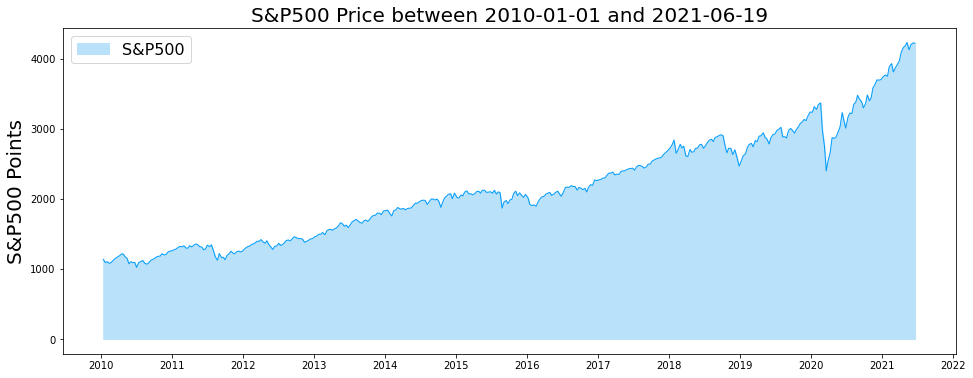

In [3]:
# Visualizing the data
register_matplotlib_converters()
years = mdates.YearLocator()
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df_weekly.index
y = df_weekly["Close"]
ax1.fill_between(x, 0, y, color="#b9e1fa")
ax1.legend([stockname], fontsize=16)
plt.title(stockname + " Price between " + date_start + " and " + date_today, fontsize=20)
plt.plot(y, color="#039dfc", label="S&P500", linewidth=1.0)
plt.ylabel("S&P500 Points", fontsize=20)
plt.show()

# Step #3 Preprocess the Data

In [4]:
# Feature Selection - Only Close Data
data = df.filter(['Close'])
data_unscaled = data.values

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

In [5]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

(2258, 50, 1) (2258,)
(577, 50, 1) (577,)
0.5340487524882027
0.5340487524882027


# Step #4 Train the Model

In [6]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons Neurons
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

50 50 1


In [7]:
# Training the model
epochs = 10
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=16, 
                    epochs=epochs, 
                    callbacks=[early_stop])

Epoch 1/10
142/142 [==============================] - 8s 59ms/step - loss: 0.0037
Epoch 2/10
142/142 [==============================] - 8s 55ms/step - loss: 1.5486e-04
Epoch 3/10
142/142 [==============================] - 8s 57ms/step - loss: 1.7584e-04
Epoch 4/10
142/142 [==============================] - 8s 57ms/step - loss: 1.5311e-04
Epoch 5/10
142/142 [==============================] - 7s 52ms/step - loss: 1.4038e-04
Epoch 6/10
142/142 [==============================] - 7s 49ms/step - loss: 1.4728e-04
Epoch 7/10
142/142 [==============================] - 7s 48ms/step - loss: 1.3719e-04
Epoch 8/10
142/142 [==============================] - 7s 48ms/step - loss: 1.3168e-04
Epoch 9/10
142/142 [==============================] - 7s 47ms/step - loss: 1.7932e-04
Epoch 10/10
142/142 [==============================] - 7s 49ms/step - loss: 1.1634e-04


# Step #5 Evaluate Model Performance

In [8]:
# Get the predicted values
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

In [9]:
# Get the root mean squarred error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE: ' + str(round(rmse, 1)))

# Get the meadian error (ME)
me = np.median(y_test-predictions)
print('ME: ' + str(round(me, 1)))

# Get the mean absolute error
mae = mean_absolute_error(y_test, predictions)
print('MAE: %f' % mae)

RMSE: 3211.4
ME: -3094.0
MAE: 3211.445869


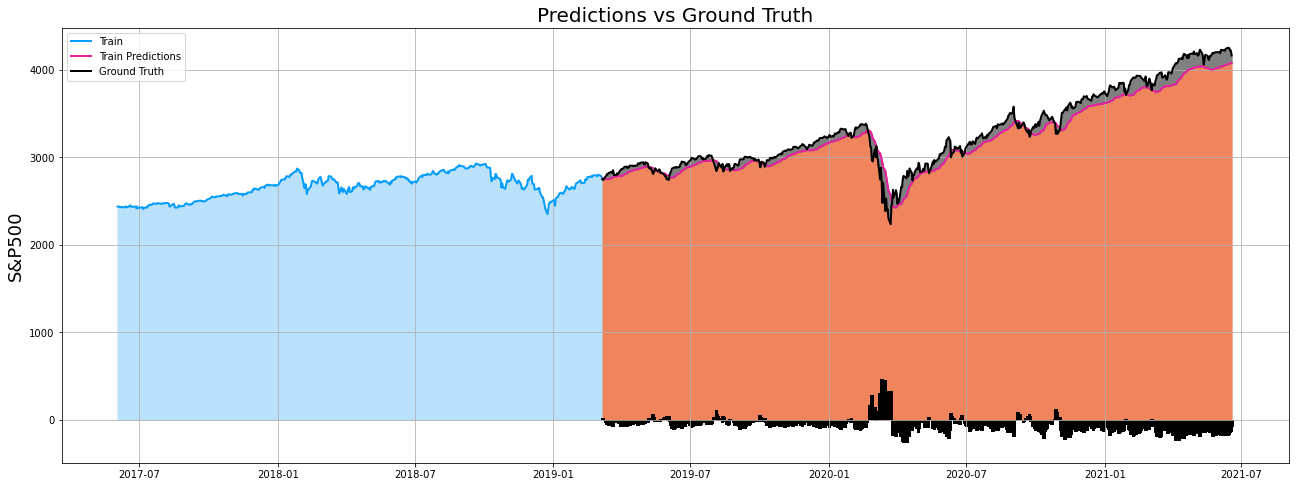

In [10]:
# The date from which on the date is displayed
display_start_date = "2017-06-01" 

train_length = train_data.shape[0]
# Add the difference between the valid and predicted prices
train = data[:train_length + 1]
valid = data[train_length:]
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 8), sharex=True)
xt = train.index; yt = train[["Close"]]
xv = valid.index; yv = valid[["Close", "Predictions"]]
plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(yt, color="#039dfc", linewidth=2.0)
plt.plot(yv["Predictions"], color="#E91D9E", linewidth=2.0)
plt.plot(yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Train Predictions", "Ground Truth"], loc="upper left")

# Fill between plotlines
ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Predictions"], color="#F0845C")
ax1.fill_between(xv, yv["Close"], yv["Predictions"], color="grey") 

# Create the bar plot with the differences
x = valid.index
y = valid["Difference"]
plt.bar(x, y, width=5, color="black")
plt.grid()
plt.show()

<BarContainer object of 577 artists>

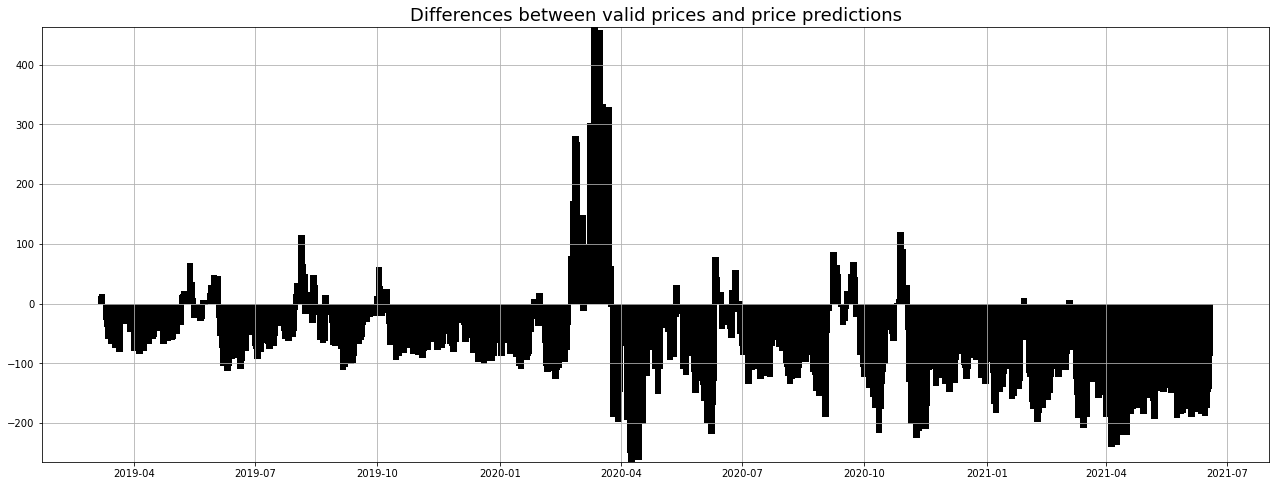

In [11]:
# Add the difference between the valid and predicted prices
diffdf = valid
differences = diffdf["Predictions"] - diffdf["Close"]
diffdf.loc[:, "difference"] = differences
x = diffdf.index
y = diffdf["difference"]

# Create the bar plot with the differences
plt.subplots(figsize=(22, 8))
plt.grid()
low = min(y)
high = max(y)
plt.ylim([low, high])
plt.title("Differences between valid prices and price predictions", fontsize=18)
plt.bar(x, y, width=5, color="black")

# Step #6 Predict Next Day's Price

In [15]:
# Get fresh data until today and create a new dataframe with only the price data
price_quote = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
new_df = price_quote.filter(['Close'])

# Get the last 50 day closing price values and scale the data to be values between 0 and 1
last_50_weeks = new_df[-50:].values
last_50_weeks_scaled = mmscaler.transform(last_50_weeks)

# Create an empty list and append past 50 weeks
X_test = []
X_test.append(last_50_weeks_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price and undo the scaling
pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(new_df['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

plus = '+'; minus = '-'
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if percent > 0 else minus}{percent}%)')

The close price for S&P500 at 2021-06-19 was 4166.45
The predicted close price is 4076.18994140625 (+2.17%)
